In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
import zipfile
import tensorflow as tf
import cv2
from math import pi,cos,sin
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from math import pi,cos,sin
%load_ext tensorboard

In [3]:
with zipfile.ZipFile('../input/facial-keypoints-detection/training.zip') as f:
    f.extractall('./')
with zipfile.ZipFile("../input/facial-keypoints-detection/test.zip") as f:
    f.extractall('./')

In [4]:
train=pd.read_csv('./training.csv')
test=pd.read_csv("./test.csv")
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


**Data Exploration**

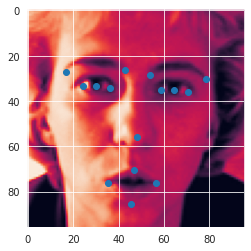

In [5]:
row=train.loc[1]
points=row.drop('Image').values
image=row['Image']
image=np.array(list(map(int,image.split(" "))))
image=image.reshape((96,96,1))
plt.imshow(image)
plt.scatter(points[0::2],points[1::2])

In [6]:
print(train.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

**Data Preperation and Augmentation**

In [7]:
clean_train_data=train.dropna()
unclean_train_data=train.fillna(method='ffill')
print(clean_train_data.shape)
print(unclean_train_data.shape)

(2140, 31)
(7049, 31)


In [8]:
def load_images(data):
    images=[]
    for idx,row in data.iterrows():
        image=np.array(row['Image'].split(" "),dtype=int)
        image=np.reshape(image,(96,96,1))
        images.append(image)
    return np.array(images)/255
def load_point(data):
    new_data=data.drop('Image',axis=1)
    points=[]
    for idx,p in new_data.iterrows():
        points.append(p)
    points=np.array(points,dtype='float')
    return points
clean_images=load_images(clean_train_data)
clean_keypoints=load_point(clean_train_data)

non_clean_images=load_images(unclean_train_data)
non_clean_keypoints=load_point(unclean_train_data)

X,y=np.concatenate((clean_images,non_clean_images)),np.concatenate((clean_keypoints,non_clean_keypoints))

In [9]:

def Rotate(images,keypoints):
    rotated_images=[]
    rotated_keypoints=[]
    for angle in [-12,12]:
        M=cv2.getRotationMatrix2D((48,48),angle,scale=1)
        radian=-angle*pi/180
        for image in images:
            rotated_image=cv2.warpAffine(image,M,(96,96),flags=cv2.INTER_CUBIC)
            rotated_images.append(rotated_image)
        for keypoint in keypoints:
            rotated_keypoint=keypoint-48
            for i in range(0,len(keypoint),2):
                rotated_keypoint[i]=rotated_keypoint[i]*cos(radian)+rotated_keypoint[i+1]*sin(radian)
                rotated_keypoint[i+1]=rotated_keypoint[i]*sin(radian)+rotated_keypoint[i+1]*cos(radian)
            rotated_keypoint+=48
            rotated_keypoints.append(rotated_keypoint)
    return np.reshape(rotated_images,(-1,96,96,1)),rotated_keypoints
rotated_images,rotated_keypoints=Rotate(clean_images,clean_keypoints)
X=np.concatenate((X,rotated_images))
y=np.concatenate((y,rotated_keypoints))

            
        
    

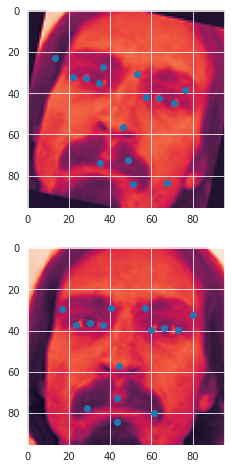

In [10]:
fig,ax=plt.subplots(2,figsize=(8,8))
ax[0].imshow(rotated_images[0])
ax[0].scatter(rotated_keypoints[0][0::2],rotated_keypoints[0][1::2])
ax[1].imshow(X[0])
ax[1].scatter(y[0,0::2],y[0,1::2])

In [11]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))
altered_brightness_images,altered_brightness_keypoints=alter_brightness(clean_images,clean_keypoints)
X=np.concatenate((X,altered_brightness_images))
y=np.concatenate((y,altered_brightness_keypoints))


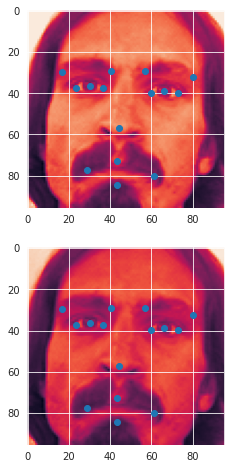

In [12]:
fig,ax=plt.subplots(2,figsize=(8,8))
ax[0].imshow(altered_brightness_images[0])
ax[0].scatter(altered_brightness_keypoints[0][0::2],altered_brightness_keypoints[0][1::2])
ax[1].imshow(X[0])
ax[1].scatter(y[0,0::2],y[0,1::2])

In [13]:
def shift_images(images,keypoints):
    shifted_images=[]
    shifted_keypoints=[]
    for (shift_X,shift_y) in [(-12,-12),(-12,12),(12,-12),(12,12)]:
        M=np.float32([[1,0,shift_X],[0,1,shift_y]])
        for image,keypoint in zip(images,keypoints):
            shifted_image=cv2.warpAffine(image,M,(96,96))
            shifted_keypoint=np.array([(point+shift_X) if idx%2==0 else (point+shift_y) for idx,point in enumerate(keypoint)])
            if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                shifted_images.append(shifted_image.reshape(96,96,1))
                shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints=np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images,shifted_keypoints
shifted_images,shifted_keypoints=shift_images(clean_images,clean_keypoints)
X=np.concatenate((X,shifted_images))
y=np.concatenate((y,shifted_keypoints))

        
            
    

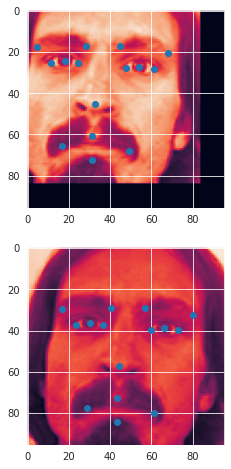

In [14]:
fig,ax=plt.subplots(2,figsize=(8,8))
ax[0].imshow(shifted_images[0])
ax[0].scatter(shifted_keypoints[0][0::2],shifted_keypoints[0][1::2])
ax[1].imshow(X[0])
ax[1].scatter(y[0,0::2],y[0,1::2])

In [15]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images
noisy_images=add_noise(clean_images)
X=np.concatenate((X,noisy_images))
y=np.concatenate((y,clean_keypoints))

**Model**

In [16]:
pretrained_model=tf.keras.applications.MobileNet(input_shape=[96,96,3],classes=30,include_top=False,weights='imagenet')
pretrained_model.trainable=True

17227776/17225924 [==============================] - 0s 0us/step


In [17]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(3,(1,1),padding='same',input_shape=(96,96,1)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30)

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                30750     
Total params: 3,259,620
Trainable params: 3,237,732
Non-trainable params: 21,888
_________________________________________

In [18]:
from  datetime import datetime

In [19]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)
logdir='logs/train/'+datetime.now().strftime("%Y%M%D-%H%M%S")
tb=tf.keras.callbacks.TensorBoard(logdir)
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']
)

model.compile(loss='mean_squared_error',metrics=['mae','acc'],optimizer='adam')
model.fit(X,y,epochs=150,validation_split=0.05, callbacks=[es, rlp,tb],batch_size=64)
%tensorboard --logdir logs

Epoch 1/150
390/390 [==============================] - 33s 65ms/step - loss: 521.0885 - mae: 13.2414 - acc: 0.3769 - val_loss: 10.4548 - val_mae: 2.5049 - val_acc: 0.6242
Epoch 2/150
390/390 [==============================] - 23s 59ms/step - loss: 6.5503 - mae: 1.8488 - acc: 0.7585 - val_loss: 12.8603 - val_mae: 2.9955 - val_acc: 0.6448
Epoch 3/150
390/390 [==============================] - 23s 59ms/step - loss: 3.8968 - mae: 1.4626 - acc: 0.8109 - val_loss: 3.2745 - val_mae: 1.4011 - val_acc: 0.7386
Epoch 4/150
390/390 [==============================] - 23s 59ms/step - loss: 3.3000 - mae: 1.3468 - acc: 0.8373 - val_loss: 2.5450 - val_mae: 1.2399 - val_acc: 0.7721
Epoch 5/150
390/390 [==============================] - 23s 59ms/step - loss: 2.6887 - mae: 1.2251 - acc: 0.8447 - val_loss: 4.0608 - val_mae: 1.4596 - val_acc: 0.6021
Epoch 6/150
390/390 [==============================] - 23s 59ms/step - loss: 2.7379 - mae: 1.2400 - acc: 0.8539 - val_loss: 3.8967 - val_mae: 1.5601 - val_acc: 

In [21]:
!mkdir -p saved_model

In [22]:
model.save('saved_model/my_model')

In [24]:
test_images=load_images(test)
predictions=model.predict(test_images)
    
    

In [ ]:
sub.imshow(test_images[0])
plt.scatter(predictions[0][0::2],predictions[0][1::2])

In [35]:
idlookup=pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv')
idlookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [38]:
Row_Id=list(idlookup['RowId'])
Image_Id=list(idlookup['ImageId']-1)
FeatureNames=list(idlookup['FeatureName'])

features=[]
for feature in FeatureNames:
    features.append(FeatureNames.index(feature))
pred=[]
for x,y in zip(Image_Id,features):
    pred.append(predictions[x][y])



In [46]:
row_id=pd.Series(Row_Id,name='RowId')
location=pd.Series(pred,name='Location')
location=location.clip(0.0,96.0)
sub=pd.concat([row_id,location],axis=1)
sub.to_csv("Facial_Keypoints_Detection.csv",index=False)

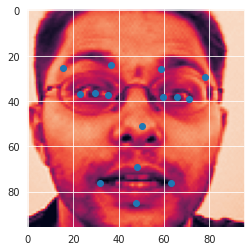

In [33]:
sub.imshow(test_images[0])
plt.scatter(predictions[0][0::2],predictions[0][1::2])